In [33]:
def News_parser(N_days=3,quote='Apple',N_top=100,API='108adbad1d494f379a818f40aec19b41',cloud_png=True,save_data=True, save_file='new_parse.csv',language='ru'):

       """
       Данный парсер предназначен, в первую очередь, для личного использования,
       а не для коммерческих целей. API следует поменять на свой в первую же очередь,
       однако, мой бесплатный всё равно мне не жалко. Пользуйтесь!
       Внимание, так как мой API имеет уровень доступа Developer, то я могу посмотреть лишь 500 запросов.
       Я добавил автоматическое определение премиумного аккаунта.
       ---------------------------------
       Описание переменных:
       N_days - Кол-во дней до текущего дня, по которым будем собираться анализ
       quote - Ключевые слова запроса на поиск новостей
       N_top - Максимальное кол-во слов, которое будет записано в БД
       API - ваш api с newsapi.org
       language - язык поиска новостей
       save_data - сохранять ли значения в файл
       save_file - название файла, куда будут записываться результаты
       cloud_png - рисовать ли Cloud картинки
       """

       import requests
       import pandas as pd
       import datetime

       was_file=False

       if language=='ru':
              stopword_lang='russian'
       if language=='en':
              stopword_lang='english'



       if save_data:
              import os
              path='data/'+save_file

              if not os.path.exists('data/'):
                     os.mkdir("data")

              if os.path.exists(path):
                     df_date=pd.read_csv(path)
                     was_file=True
              else:
                     df_date=pd.DataFrame() # Фрейм с готовыми скорингами слов с разбиением по датам
       
       else:
              df_date=pd.DataFrame() # Фрейм с готовыми скорингами слов с разбиением по датам
       

       for num in range(1,N_days+1):
              
              page_n=1
              current_date = datetime.datetime.today().date()
              prep_date=(current_date-datetime.timedelta(days=num))

              can_do=True
              if was_file:
                     
                     if len(df_date.loc[(df_date["Theme"]==quote) & (df_date['Date']==str(prep_date)) & (df_date['Language']==language)])>0:
                            print(f"Be careful next, found the same quote-{quote} on date-{prep_date} ")
                            can_do=False
                     else:
                            can_do=True
              if can_do:
                     print(f"Парсинг на дату: {prep_date}\n-------------------------------")

                     url = ('https://newsapi.org/v2/everything?'
                            f'q={quote}&'
                            f'language={language}&'
                            # 'country=fr&'
                            f'from={prep_date.year}-{prep_date.month}-{prep_date.day}&'
                            f'to={prep_date.year}-{prep_date.month}-{prep_date.day}&'
                            f'page={page_n}&'
                            'sortBy=popularity&'
                            f'apiKey={API}')

                     response = requests.get(url)
                     data=response.json() # Преобразовываем данные в json формат (словарь)
                     
                     # Раскоментить если хочется посмотреть какого формата ответы
                     # print(json.dumps(data, indent=4, sort_keys=True, ensure_ascii=False)) # без параметра ensure_ascii=False будет слетать кодировка и вместо русских символов будет \u0412\u0438\u043a\u0442
                     # print(data['totalResults']//100)

                     parsed=pd.DataFrame()
                     dates=[]
                     titles=[]
                     descriptions=[]
                     authors=[]

                     pages=data['totalResults']//100

                     for state in data['articles']:
                            dates.append(state['publishedAt'])
                            titles.append(state['title'])
                            descriptions.append(state['description'])
                            authors.append(str(state['source']['name']))

                     if pages>1:
                            for i in range(2,data['totalResults']//100+2):

                                   page_n=i
                                   url = ('https://newsapi.org/v2/everything?'
                                          f'q={quote}&'
                                          f'language={language}&'
                                          # 'country=fr&'
                                          f'from={prep_date.year}-{prep_date.month}-{prep_date.day}&'
                                          f'to={prep_date.year}-{prep_date.month}-{prep_date.day}&'
                                          f'page={page_n}&'
                                          'sortBy=popularity&'
                                          f'apiKey={API}')
                                   response = requests.get(url)
                                   data=response.json()

                                   if data["status"]=="ok":
                                          for state in data['articles']:
                                                 dates.append(state['publishedAt'])
                                                 titles.append(state['title'])
                                                 descriptions.append(state['description'])
                                                 authors.append(str(state['source']['name']))
                                   else:
                                          if "Developer accounts are limited" in data["message"]:
                                                 print('Достигли ограничения по запросам для dev-acc. Прекращаем')
                                                 break
                                          print(f"Произошла ошибка на странице {page_n}. Код: {data['status']}")

                     parsed["Date"]=dates
                     parsed["Title"]=titles
                     parsed["Describe"]=descriptions
                     parsed["Author"]=authors

                     if len(parsed)==0:
                            print(f"Данных по ключу-{quote}, на дату-{prep_date} = НЕТ\nВозможно данных просто нет, или же данные пока не появились, попробуйте позже повторить запрос")
                     else:

                            def cutter(x,n):
                                   if n==1:
                                          return int(x[0:4])
                                   if n==2:
                                          return int(x[5:7])
                                   if n==3:
                                          return int(x[8:10])
                                   
                            parsed['Year']=parsed['Date'].apply(lambda x: cutter(x,1))
                            parsed['Month']=parsed['Date'].apply(lambda x: cutter(x,2))
                            parsed['Day']=parsed['Date'].apply(lambda x: cutter(x,3))

                            parsed.drop(['Describe'],axis=1,inplace=True) # Можно и оставить
                            parsed.drop(['Date'],axis=1,inplace=True) # Можно и оставить

                            parsed.drop_duplicates()

                            from wordcloud import WordCloud
                            import matplotlib.pyplot as plt
                            
                            # Импортируем библиотеку для лемматизации русских и украинских слов
                            import pymorphy2
                            # Импортируем метод word_tokenize из библиотеки nltk
                            from nltk.tokenize import word_tokenize 
                            
                            from nltk.corpus import stopwords
                            stop_words = stopwords.words(stopword_lang)

                            stop_append=[',','.','%',
                                   ':',
                                   '—',
                                   '«',
                                   '»',
                                   'лайфхакер',
                                   'подкаст',
                                   'который',
                                   'нрф',
                                   'ия',
                                   '',
                                   '',
                                   '',
                                   ]
                            stop_words=stop_words+stop_append

                            text = ' '.join(parsed['Title'])
                            # print(type(text)) 
                            # разбиваем текст на токены
                            # в результате получаем переменную типа list со списком токенов
                            text = word_tokenize(text,)

                            # инициализируем лемматайзер MorphAnalyzer()
                            lemmatizer = pymorphy2.MorphAnalyzer()
                            
                            # функция для лемматизации текста, на вхд принимает список токенов 
                            def lemmatize_text(tokens):
                            # создаем переменную для хранения преобразованного текста
                                   text_new=''
                                   # для каждого токена в тексте
                                   for word in tokens:
                                          # с помощью лемматайзера получаем основную форму
                                          word = lemmatizer.parse(word)
                                          # добавляем полученную лемму в переменную с преобразованным текстом
                                          text_new = text_new + ' ' + word[0].normal_form
                                   # возвращаем преобразованный текст
                                   return text_new
                            
                            text=[word for word in text if word not in stop_words]

                            # вызываем функцию лемматизации для списка токенов исходного текста
                            text = lemmatize_text(text)
                            # генерируем облако слов
                            cloud = WordCloud(stopwords=stop_words, width=1920, height=1080,random_state=4, 
                                                 contour_width=10, contour_color='#2e3043', background_color='#272d3b', colormap='Set3' ).generate(text)
                            
                            if cloud_png:
                                   plt.figure(figsize=(9,5))
                                   plt.imshow(cloud)
                                   plt.axis('off')



                            if len(cloud.words_.items())<N_top:
                                   N_top=len(cloud.words_.items())

                            titles=[]
                            scores=[]
                            years=[prep_date]*N_top
                            quotes=[quote]*N_top
                            langs=[language]*N_top
                            i=0
                            for word in cloud.words_.items():
                                   if i<N_top and i<len(cloud.words_.items()):
                                          titles.append(word[0])
                                          scores.append(word[1])
                                          i+=1

                            df_current=pd.DataFrame()
                            df_current["Name"]=titles
                            df_current["Score"]=scores
                            df_current["Date"]=years
                            df_current["Theme"]=quotes
                            df_current['Language']=langs
                            # print(df_current.head(10))
                            df_date=pd.concat([df_date,df_current])

       print(f"Парсинг прошёл успешно")
       print(df_date.head(3))
       if save_data:
              df_date.to_csv(path, index=False)
       else:
              return df_date



Парсинг на дату: 2023-11-01
-------------------------------
Данных по ключу-Воронин, на дату-2023-11-01 = НЕТ
Возможно данных просто нет, или же данные пока не появились, попробуйте позже повторить запрос
Парсинг на дату: 2023-10-31
-------------------------------
Данных по ключу-Воронин, на дату-2023-10-31 = НЕТ
Возможно данных просто нет, или же данные пока не появились, попробуйте позже повторить запрос
Парсинг на дату: 2023-10-30
-------------------------------
Данных по ключу-Воронин, на дату-2023-10-30 = НЕТ
Возможно данных просто нет, или же данные пока не появились, попробуйте позже повторить запрос
Парсинг на дату: 2023-10-29
-------------------------------
Данных по ключу-Воронин, на дату-2023-10-29 = НЕТ
Возможно данных просто нет, или же данные пока не появились, попробуйте позже повторить запрос
Парсинг на дату: 2023-10-28
-------------------------------
Данных по ключу-Воронин, на дату-2023-10-28 = НЕТ
Возможно данных просто нет, или же данные пока не появились, попробуйт

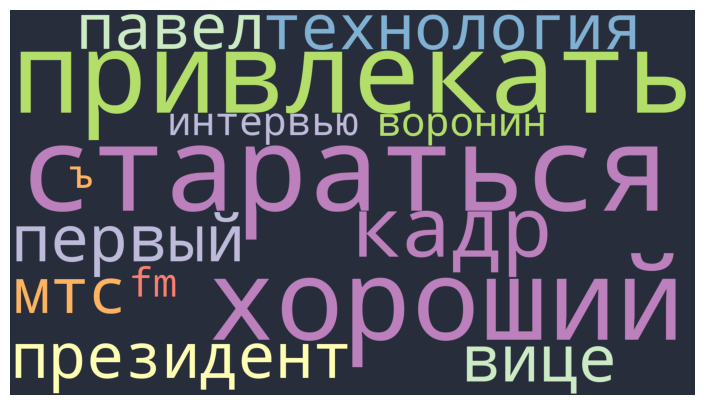

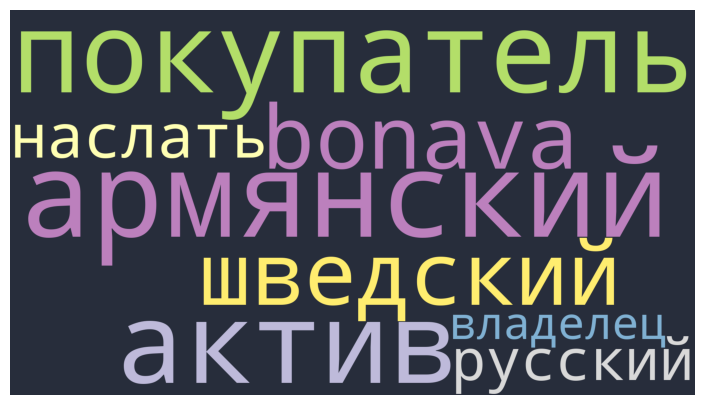

In [35]:
quote='Воронин'
language='ru'
N_days=20
N_top=100
API='108adbad1d494f379a818f40aec19b41'
cloud_png=True
save_data=True
save_file='new_parse.csv'
News_parser(N_days=N_days,quote=quote,N_top=N_top,API=API,cloud_png=cloud_png,
            save_data=save_data, save_file=save_file,language=language)

In [3]:
# print(text)
# text2 = word_tokenize(text)
# print(text2, len(text2), sep="\n")
# text2=[word for word in text2 if word not in stop_words]
# print(text2, len(text2),sep="\n")
# print(stop_words )

In [4]:
# import nltk.downloader
# nltk.download('stopwords')

In [32]:
import requests
import json
url = ('https://newsapi.org/v2/everything?'
       'q=Apple&'
       'from=2023-10-30&'
       'sortBy=popularity&'
       'page=6&'
       'apiKey=108adbad1d494f379a818f40aec19b41')

response = requests.get(url)

print (response.json())

{'status': 'error', 'code': 'maximumResultsReached', 'message': 'You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 120. Please upgrade to a paid plan if you need more results.'}
